# Import

In [ ]:
pip install --upgrade keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 35.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from numpy import load
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy, Precision, Recall, CategoricalAccuracy
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, GlobalAveragePooling2D
from keras import ops
import keras.optimizers
from PIL import Image
from IPython.display import clear_output
import keras_cv
from keras_cv.layers import RandomApply
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.ticker as ticker
from tensorflow.keras.callbacks import LearningRateScheduler
import pickle

In [ ]:
# Mounts Google Drive and load data
drive.mount('/gdrive')
data = load('/gdrive/MyDrive/blood/data_preprocessed_unbalanced.npz', allow_pickle=True)

Mounted at /gdrive


In [ ]:
# Import data
X_train = data['train_images']
y_train = data['train_labels']
X_test = data['val_images']
y_test = data['val_labels']

# Dataset creation

In [ ]:
# Create a mapping from unique labels to integers
unique_labels = np.unique(y_train)
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Convert labels to integers using the mapping
numeric_labels = np.array([label_mapping[label] for label in y_train])

# Find the number of unique labels
num_classes = len(unique_labels)

# Convert labels to one-hot encoded vectors
y_train = to_categorical(numeric_labels, num_classes=num_classes)

In [ ]:
# Create a mapping from unique labels to integers for validation labels
unique_val_labels = np.unique(y_test)
val_label_mapping = {label: i for i, label in enumerate(unique_val_labels)}

# Convert validation labels to integers using the mapping
numeric_val_labels = np.array([val_label_mapping[label] for label in y_test])

# Find the number of unique validation labels
num_val_classes = len(unique_val_labels)

# Convert validation labels to one-hot encoded vectors
y_test = to_categorical(numeric_val_labels, num_classes=num_val_classes)

In [ ]:
del data
del unique_labels
del label_mapping
del numeric_labels
del num_classes
del unique_val_labels
del val_label_mapping
del numeric_val_labels
del num_val_classes

In [ ]:
# Create dataset object
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
del X_train
del y_train
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
del X_test
del y_test

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 10755
Validation dataset size: 1196


In [ ]:
# Set batch size
train_dataset = train_dataset.batch(8)
val_dataset = val_dataset.batch(8)

In [ ]:
# # Number of images to display
# num_images = 10
# # Number of columns in the grid
# num_cols = 5
# # Number of rows in the grid
# num_rows = math.ceil(num_images / num_cols)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# for i, (image_batch, label_batch) in enumerate(train_dataset_augmented.take(num_images)):
#     row = i // num_cols
#     col = i % num_cols

#     axes[row, col].imshow(image_batch[0])
#     axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

# Augmentation

In [ ]:
# Create custom class for augmentation
class RandomTranslateRotate(tf.keras.layers.Layer):
    def __init__(self, direction_up, **kwargs):
        super(RandomTranslateRotate, self).__init__(**kwargs)
        self.direction_up = direction_up

    def call(self, inputs, training=True):
        if training:
            # Apply RandomTranslation
            if(self.direction_up):
              translate_layer = keras_cv.layers.RandomTranslation((0.05, 0.05), 0, fill_mode="constant")
            else:
              translate_layer = keras_cv.layers.RandomTranslation(0,(0.05,0.05), fill_mode="constant")
            translated_image = translate_layer(inputs)

            if(self.direction_up):
              translate_layer = keras_cv.layers.RandomTranslation((0.3,0.4), 0)
            else:
              translate_layer = keras_cv.layers.RandomTranslation(0, (0.3,0.4))
            translated_image = translate_layer(translated_image)

            rotation = keras_cv.layers.RandomRotation((0.1,0.15), fill_mode="reflect")

            return rotation(translated_image)
        else:
            return inputs

    def get_config(self):
        config = super(RandomTranslateRotate, self).get_config()
        config.update({'translate_factor': self.translate_factor, 'rotate_factor': self.rotate_factor})
        return config

In [ ]:
# Create augmentation and apply it to dataset
random_layers = [
    RandomApply(RandomTranslateRotate(direction_up=True), rate=0.15),
    RandomApply(keras_cv.layers.JitteredResize((96, 96), (0.93, 0.93)), rate=0.3),
    RandomApply(keras_cv.layers.GridMask(ratio_factor=(0, 0.5), rotation_factor=0.15, fill_mode="constant"), rate=0.1),
    RandomApply(keras_cv.layers.RandAugment((0, 1), magnitude=0.5), rate=0.4),
    RandomApply(keras_cv.layers.RandomBrightness(0.25, value_range=(0, 1)), rate=0.2),
    RandomApply(RandomTranslateRotate(direction_up=False), rate=0.15),
    RandomApply(keras_cv.layers.RandomSaturation(0.5), rate=0.2),
    RandomApply(keras_cv.layers.RandomContrast((0, 1), 0.25), rate=0.2),
    RandomApply(keras_cv.layers.RandomCutout(0.2,0.2,fill_mode="constant"), rate=0.2),
    RandomApply(keras_cv.layers.RandomColorDegeneration(0.25), rate=0.2),
    RandomApply(RandomTranslateRotate(direction_up=False), rate=0.15),
    RandomApply(keras_cv.layers.RandomChannelShift((0,1),1), rate=0.2),
    RandomApply(keras_cv.layers.RandomShear(1), rate=0.4),
    RandomApply(RandomTranslateRotate(direction_up=True), rate=0.15),
    RandomApply(keras_cv.layers.Solarization((0, 0.6)), rate=0.2),
]

augmenter = tfk.Sequential(random_layers)

train_dataset_augmented = train_dataset.map(
    lambda x, y: (augmenter(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Apply augmentation to validation set
val_dataset_augmented = val_dataset.map(
    lambda x, y: (augmenter(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Increase resolution of images to match input shape of model
def preprocess_image(image, label):
  """Resizes and preprocesses the image."""
  image = tf.image.resize(image, [224, 224])
  # Add any other preprocessing steps if needed
  return image, label

train_dataset_augmented = train_dataset_augmented.map(preprocess_image)
val_dataset_augmented = val_dataset_augmented.map(preprocess_image)

In [ ]:
del train_dataset
del val_dataset

In [ ]:
# # Number of images to display
# num_images = 10
# # Number of columns in the grid
# num_cols = 5
# # Number of rows in the grid
# num_rows = math.ceil(num_images / num_cols)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# for i in range(10):
#     row = i // num_cols
#     col = i % num_cols
#     for image_batch, label_batch in (train_dataset_augmented.take(1)):
#       axes[row, col].imshow(image_batch[0])
#       axes[row, col].axis('off')


# plt.tight_layout()
# plt.show()

# Import model

In [ ]:
# Import model
final_model = keras.models.load_model('/gdrive/MyDrive/blood/blood17xl-10ep17ep.keras', compile=False)

In [ ]:
import keras.applications

# Import pretrained model
model = keras.applications.ConvNeXtXLarge(
    include_top=False,
    include_preprocessing=False,
    weights="imagenet",
    input_shape=(224,224,3),
)

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 39s 0us/step


In [ ]:
# Freeze the layers of the pre-trained model
for layer in model.layers:
  layer.trainable = False

# Create a new Model using the Functional API
input_tensor = model.input

# Get the output tensor of the layer before the one to be removed
x = model.layers[-2].output
x = GlobalAveragePooling2D()(x)
x = LayerNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

# Create the new model
final_model = tf.keras.Model(inputs=input_tensor, outputs=outputs)
final_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stem      │ (None, 56, 56, 256)    │         13,056 │ input_layer_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 256)    │         12,800 │ convnext_xlarge_stem[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 256)    │            512 │ convnext_xlarge_stage… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 1024)   │        263,168 │ convnext_xlarge_stage… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 1024)   │              0 │ convnext_xlarge_stage… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 256)    │        262,400 │ convnext_xlarge_stage… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 256)    │            256 │ convnext_xlarge_stage… │
│ (LayerScale)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 256)    │              0 │ convnext_xlarge_stage… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 256)    │              0 │ convnext_xlarge_stem[… │
│                           │                        │                │ convnext_xlarge_stage… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 256)    │         12,800 │ add[0][0]              │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 256)    │            512 │ convnext_xlarge_stage… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_xlarge_stage_0_… │ (None, 56, 56, 1024)   │        263,168 │ convnext_xlarge_stage… │
│ (Dense)                   │                        │                │                        │
├──────────────────────

 Total params: 350,510,600 (1.31 GB)

 Trainable params: 2,366,728 (9.03 MB)

 Non-trainable params: 348,143,872 (1.30 GB)

# Optimization

In [ ]:
# Compile the model with AdamW optimizer
optimizer = tfk.optimizers.Lion(learning_rate=2.5e-6)

In [ ]:
# Define lr plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation loss for plateau detection
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=1,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-9,        # Minimum learning rate
    verbose=0           # Print messages when learning rate is reduced
)
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate
    return lr
lr_metric = get_lr_metric(optimizer)

In [ ]:
# Define lr schedule
def lr_scheduler(curr_epoch, curr_lr, start= 0, rate= 0.03):
    if curr_epoch < start:
        return curr_lr
    else:
        return curr_lr * np.exp(-rate)
lr_schedule = LearningRateScheduler(lr_scheduler)
# lr = 5e-5
# for i in range(50):
#   lr = lr_scheduler(i, lr)
#   print(str(i) + " " + str(lr.numpy()))

In [ ]:
# Compile model
final_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', lr_metric])

In [ ]:
print('trainable:')
for layer in final_model.layers:
  if layer.trainable:
    print(layer.name)

trainable:
global_average_pooling2d
layer_normalization_1
dense
dense_1
dense_2


# Train model

## Transfer learning

In [ ]:
history = {}

In [ ]:
# with open("/gdrive/MyDrive/blood/history.pkl", "rb") as file:
#     history = pickle.load(file)

In [ ]:
# Train the model and store the training history
new_history = final_model.fit(
    x=train_dataset_augmented,
    epochs=5,
    validation_data=val_dataset_augmented,
    callbacks=[reduce_lr, lr_schedule],
).history

history.update({k: history.get(k, []) + new_history.get(k, []) for k in set(history) | set(new_history)})

Epoch 1/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 681s 975ms/step - accuracy: 0.7431 - loss: 0.7309 - lr: 2.7972e-05 - val_accuracy: 0.7483 - val_loss: 0.7239 - val_lr: 2.7972e-05 - learning_rate: 2.7972e-05
Epoch 2/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 684s 984ms/step - accuracy: 0.7514 - loss: 0.6985 - lr: 2.6081e-05 - val_accuracy: 0.7600 - val_loss: 0.7006 - val_lr: 2.6081e-05 - learning_rate: 2.6081e-05
Epoch 3/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 671s 992ms/step - accuracy: 0.7574 - loss: 0.6935 - lr: 2.4318e-05 - val_accuracy: 0.7492 - val_loss: 0.6924 - val_lr: 2.4318e-05 - learning_rate: 1.2159e-05
Epoch 4/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 668s 972ms/step - accuracy: 0.7557 - loss: 0.6805 - lr: 1.1337e-05 - val_accuracy: 0.7366 - val_loss: 0.7320 - val_lr: 1.1337e-05 - learning_rate: 5.6684e-06
Epoch 5/5
673/673 ━━━━━━━━━━━━━━━━━━━━ 678s 967ms/step - accuracy: 0.7678 - loss: 0.6592 - lr: 5.2852e-06 - val_accuracy: 0.7659 - val_loss: 0.6842 - val_lr: 5.2852e-06 - learning_rate: 5.2852e-06


In [ ]:
# Print stats
print("Epoch\tTrain Accuracy\tValidation Accuracy\tLearning Rate")
for i in range(len(history['accuracy'])):
  print(f"{i+1}\t{history['accuracy'][i]:.4f}\t\t{history['val_accuracy'][i]:.4f}\t\t{history['lr'][i]}")

Epoch	Train Accuracy	Validation Accuracy	Learning Rate
1	0.5833		0.6789		5.000042074243538e-05
2	0.6842		0.6881		5.000042074243538e-05
3	0.7001		0.6906		5.000042074243538e-05
4	0.7066		0.7174		5.000042074243538e-05
5	0.7281		0.7391		5.000042074243538e-05
6	0.7404		0.7483		2.7971924282610416e-05
7	0.7455		0.7600		2.6080753741553053e-05
8	0.7509		0.7492		2.4317554562003352e-05
9	0.7586		0.7366		1.1336643183312844e-05
10	0.7604		0.7659		5.285195129545173e-06


In [ ]:
# Save stats to drive
with open("/gdrive/MyDrive/blood/history.pkl", "wb") as f:
    pickle.dump(history, f)

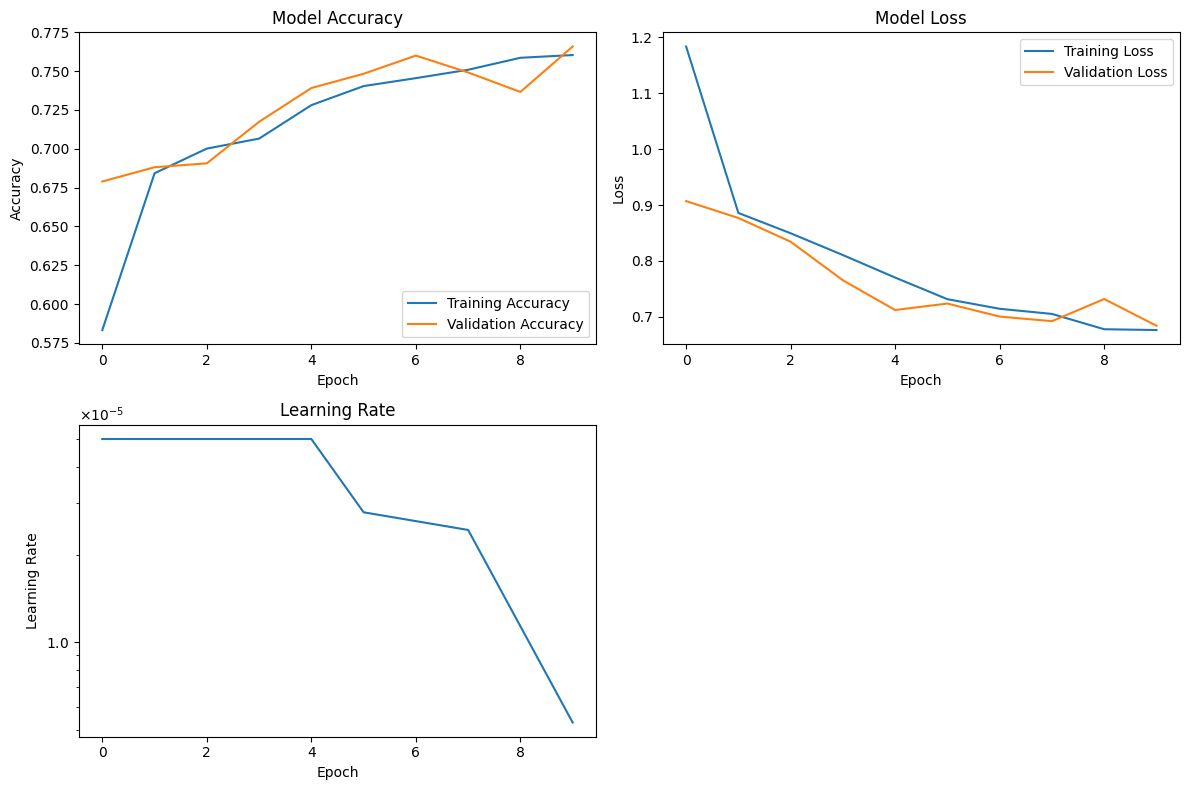

In [ ]:
# Plot training stats
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of plots

# Plot training and validation accuracy
axes[0, 0].plot(history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend(loc='lower right')

# Plot training and validation loss
axes[0, 1].plot(history['loss'], label='Training Loss')
axes[0, 1].plot(history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend(loc='upper right')

# Plot learning rate
axes[1, 0].plot(history['lr'])
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_yscale('log')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))  # Adjust power limits as needed
axes[1, 0].yaxis.set_major_formatter(formatter)

# Remove empty subplot
fig.delaxes(axes[1, 1])

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plots

## Finetuning

In [ ]:
# Train all layers
for layer in final_model.layers:#[-100:]:
  layer.trainable = True

In [ ]:
history = {}

In [ ]:
# Import past training stats from drive
with open("/gdrive/MyDrive/blood/history-ft.pkl", "rb") as file:
    history = pickle.load(file)

In [ ]:
# Train the model and store the training history
new_history = final_model.fit(
    x=train_dataset_augmented,
    epochs=5,
    validation_data=val_dataset_augmented,
    callbacks=[reduce_lr],
).history

# Calculate the final validation accuracy
history.update({k: history.get(k, []) + new_history.get(k, []) for k in set(history) | set(new_history)})

Epoch 1/5
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 1659s 1s/step - accuracy: 0.9365 - loss: 0.1868 - lr: 2.5000e-06 - val_accuracy: 0.9365 - val_loss: 0.1768 - val_lr: 2.5000e-06 - learning_rate: 2.5000e-06
Epoch 2/5
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 1537s 1s/step - accuracy: 0.9428 - loss: 0.1729 - lr: 2.5000e-06 - val_accuracy: 0.9440 - val_loss: 0.1533 - val_lr: 2.5000e-06 - learning_rate: 2.5000e-06
Epoch 3/5
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 1537s 1s/step - accuracy: 0.9454 - loss: 0.1607 - lr: 2.5000e-06 - val_accuracy: 0.9273 - val_loss: 0.1973 - val_lr: 2.5000e-06 - learning_rate: 2.5000e-06
Epoch 4/5
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 1534s 1s/step - accuracy: 0.9472 - loss: 0.1627 - lr: 1.2500e-06 - val_accuracy: 0.9490 - val_loss: 0.1721 - val_lr: 1.2500e-06 - learning_rate: 1.2500e-06
Epoch 5/5
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 1584s 1s/step - accuracy: 0.9504 - loss: 0.1404 - lr: 1.2500e-06 - val_accuracy: 0.9440 - val_loss: 0.1546 - val_lr: 1.2500e-06 - learning_rate: 1.2500e-06


In [ ]:
# Print training stats
print("Epoch\tTrain Accuracy\tValidation Accuracy\tLearning Rate")
for i in range(len(history['accuracy'])):
  print(f"{i+1}\t{history['accuracy'][i]:.4f}\t\t{history['val_accuracy'][i]:.4f}\t\t{history['lr'][i]}")

Epoch	Train Accuracy	Validation Accuracy	Learning Rate
1	0.8263		0.8645		4.999933480576146e-06
2	0.8828		0.9038		4.999933480576146e-06
3	0.9066		0.9105		4.999933480576146e-06
4	0.9171		0.9038		4.999933480576146e-06
5	0.9350		0.9356		2.499966740288073e-06
6	0.9358		0.9365		2.499966740288073e-06
7	0.9397		0.9440		2.499966740288073e-06
8	0.9423		0.9273		2.499966740288073e-06
9	0.9471		0.9490		1.2499833701440366e-06
10	0.9484		0.9440		1.2499833701440366e-06


In [ ]:
with open("/gdrive/MyDrive/blood/history-ft.pkl", "wb") as f:
    pickle.dump(history, f)

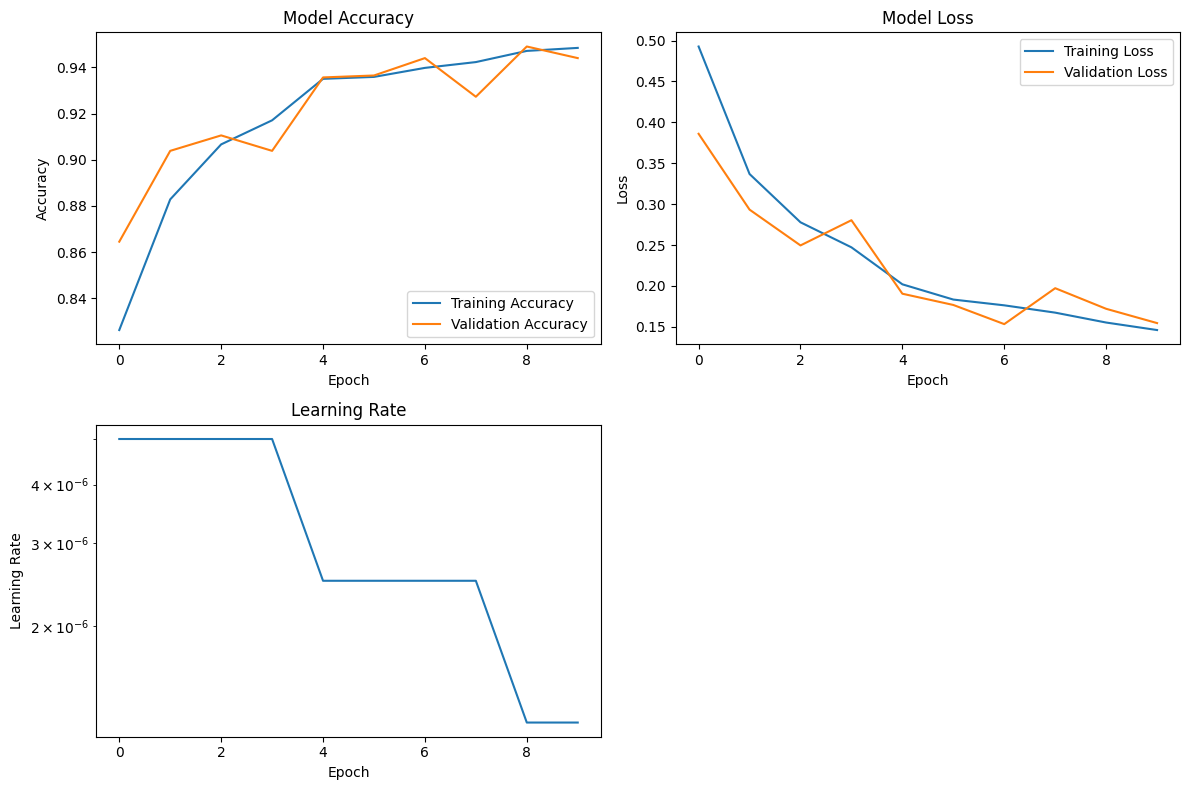

In [ ]:
# Plot training stats
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of plots

# Plot training and validation accuracy
axes[0, 0].plot(history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend(loc='lower right')

# Plot training and validation loss
axes[0, 1].plot(history['loss'], label='Training Loss')
axes[0, 1].plot(history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend(loc='upper right')

# Plot learning rate
axes[1, 0].plot(history['lr'])
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_yscale('log')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))  # Adjust power limits as needed
axes[1, 0].yaxis.set_major_formatter(formatter)

# Remove empty subplot
fig.delaxes(axes[1, 1])

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plots

In [ ]:
# Save model
final_model.save("/gdrive/MyDrive/blood/blood17xl-10ep10ep.keras")

# Build export

In [ ]:
final_model.training = False
final_model.compile(optimizer=None,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model.save("/gdrive/MyDrive/blood/export.keras")

In [ ]:
%%writefile model.py
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('export.keras', compile=False)
        self.neural_network.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=None, metrics=["accuracy"])

    def predict(self, X, batch_size=8):
        num_samples = X.shape[0]
        preds = []

        # Process input data in batches
        for i in range(0, num_samples, batch_size):
            batch = X[i:i + batch_size]

            # Resize and normalize the batch
            batch_resized = tf.image.resize(batch, [224, 224])
            batch_normalized = batch_resized / 255.0

            # Convert to tensor
            batch_tensor = tf.convert_to_tensor(batch_normalized, dtype=tf.float32)

            # Make predictions on the batch
            batch_preds = self.neural_network.predict(batch_tensor, batch_size=batch_size)
            batch_preds = np.argmax(batch_preds, axis=1)

            # Append predictions to the list
            preds.extend(batch_preds)

        return np.array(preds)


Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d")}.zip'

# Add files to the zip command if needed
!zip -j {filename} model.py /gdrive/MyDrive/blood/export.keras

  adding: model.py (deflated 57%)
  adding: export.keras (deflated 7%)


In [ ]:
import shutil
shutil.move("submission_241120.zip", "/gdrive/MyDrive/blood/submission_241120.zip")


'/gdrive/MyDrive/blood/submission_241120.zip'